# An ML primer

Department of Medical Genetics, Oslo university Hospital, Norway

This presentation was held at the Research Seminar in Strömstad, November 18th, 2015. 

Hugues Fontenelle, 2015

Note that this iPython Notebook is intended to complement the presentation held at the seminar.

## 1) biological problem

Predict whether a candidate DNA sequence is a "donor" splice site.

## 2) get data

### ref files

First we'll need refence files such as the reference genes and the assembly.
Get these files in the same folder as this ipython notebook (the fasta file is ~830 Mb compressed or 3.1Gb uncompressed).

```
wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz
wget ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/b37/human_g1k_v37.fasta.gz
wget ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/b37/human_g1k_v37.fasta.fai.gz
gunzip *
```

### True Positive set

The following python code will create the True Positive set and store in a text file named `splice_u1.txt`.

In [67]:
REFGENE = 'refGene.txt'
REFSEQ = 'human_g1k_v37.fasta'

import csv
from pyfaidx import Fasta
import random
random.seed()

def splice_u1_generator():
    refseq = Fasta(REFSEQ)
    with open(REFGENE, 'rb') as refgene:
        reader = csv.reader(refgene, delimiter='\t')
        for row in reader:
            try:
                chrom = row[2].replace('chr', '')
                strand = row[3]
                exon_starts = [int(x) for x in row[9].split(',') if x]
                exon_ends = [int(x) for x in row[10].split(',') if x]
                for exon in zip(exon_starts, exon_ends):
                    if strand == '+':
                        pos = exon[1]
                        splice_u1 = refseq[chrom][pos-3:pos+6]
                    elif strand == '-':
                        pos = exon[0]
                        splice_u1 = refseq[chrom][pos-7:pos+2].reverse.complement
                    if str(splice_u1)[3:5] == 'GT':
                        yield str(splice_u1)
            except StopIteration:
                raise
            except Exception as err:
                print 'Skipping one gene because {}'.format(err)
                continue

In [68]:
splice_gen = splice_u1_generator()

The first ten splice sites look like this:

In [69]:
for i in range(10):
    print '{}) {}'.format(i, splice_gen.next())

Skipping one gene because '6_mcf_hap5 not in human_g1k_v37.fasta.'
0) GGGGTGAGT
1) CCGGTGAGC
2) TGTGTAAGA
3) GAGGTGCCT
4) CAGGTGAGA
5) TGGGTAAGG
Skipping one gene because '6_dbb_hap3 not in human_g1k_v37.fasta.'
Skipping one gene because '6_apd_hap1 not in human_g1k_v37.fasta.'
Skipping one gene because '6_cox_hap2 not in human_g1k_v37.fasta.'
Skipping one gene because '6_dbb_hap3 not in human_g1k_v37.fasta.'
6) CAAGTAAGT
7) GAGGTGGGT
8) GAGGTACCA
9) AAGGTGGGT


Let's create the file:

In [70]:
with open('splice_u1.txt', 'w') as f:
        for i in range(1000):
            f.write(splice_gen.next() + '\n')

Skipping one gene because '6_dbb_hap3 not in human_g1k_v37.fasta.'
Skipping one gene because '6_cox_hap2 not in human_g1k_v37.fasta.'
Skipping one gene because '6_dbb_hap3 not in human_g1k_v37.fasta.'
Skipping one gene because '6_mcf_hap5 not in human_g1k_v37.fasta.'
Skipping one gene because '6_qbl_hap6 not in human_g1k_v37.fasta.'
Skipping one gene because '6_ssto_hap7 not in human_g1k_v37.fasta.'


### True Negative set

In [71]:
def random_u1():
    rnd = ''.join(random.choice('ATCG') for _ in range(7))
    u1 = rnd[:3] + 'GT' + rnd[3:]
    return u1

with open('random_u1.txt', 'w') as f:
        for i in range(1000):
            f.write(random_u1() + '\n')

## 3) Markov model

### Re-load the data

In [72]:
import numpy as np

U1 = []
with open('splice_u1.txt', 'rb') as f:
    for line in f:
        U1.append(line.strip())

U_rnd = []
with open('random_u1.txt', 'rb') as f:
    for line in f:
        U_rnd.append(line.strip())

### Compute incidence probabilities and transition probabilities (markov model)

In [73]:
 def compute_markovmodel(U1):
    tr = []
    for it in range(8):
        tr0 = {'A' : [0, {'A':0, 'T':0, 'C':0, 'G':0}], 
               'T' : [0, {'A':0, 'T':0, 'C':0, 'G':0}], 
               'C' : [0, {'A':0, 'T':0, 'C':0, 'G':0}],
               'G' : [0, {'A':0, 'T':0, 'C':0, 'G':0}]}
        for x in U1:
            tr0[x[it]][0] += 1
            tr0[x[it]][1][x[it+1]] += 1
        tr.append(tr0)
    it = 8
    tr0 = {'A' : [0], 'T' : [0], 'C' : [0], 'G' : [0]}
    for x in U1:
        tr0[x[it]][0] += 1
    tr.append(tr0)
    return tr

tr = compute_markovmodel(U1)

### Data exploration

This is not a necessary step, but we get a better feel of the data and the markov model that we just computed.

What is the pobability of a particular "letter" in first position?


In [74]:
position = 0 # just play around, change to another position and re-run the next cells

(-1.0143017794707914, 1.0080242978477674, -1.0166415513068769, 1.0)

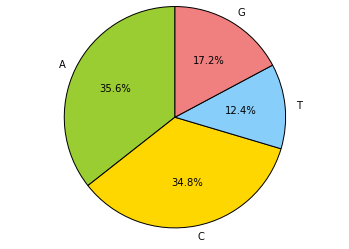

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

tr0 = tr[position]

# The slices will be ordered and plotted counter-clockwise.
alphabet = ['A', 'C', 'T', 'G']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']


plt.pie([tr0[letter][0] for letter in alphabet], labels=alphabet, colors=colors,
        autopct='%1.1f%%', startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

What is the probability of the transition from first to second position?

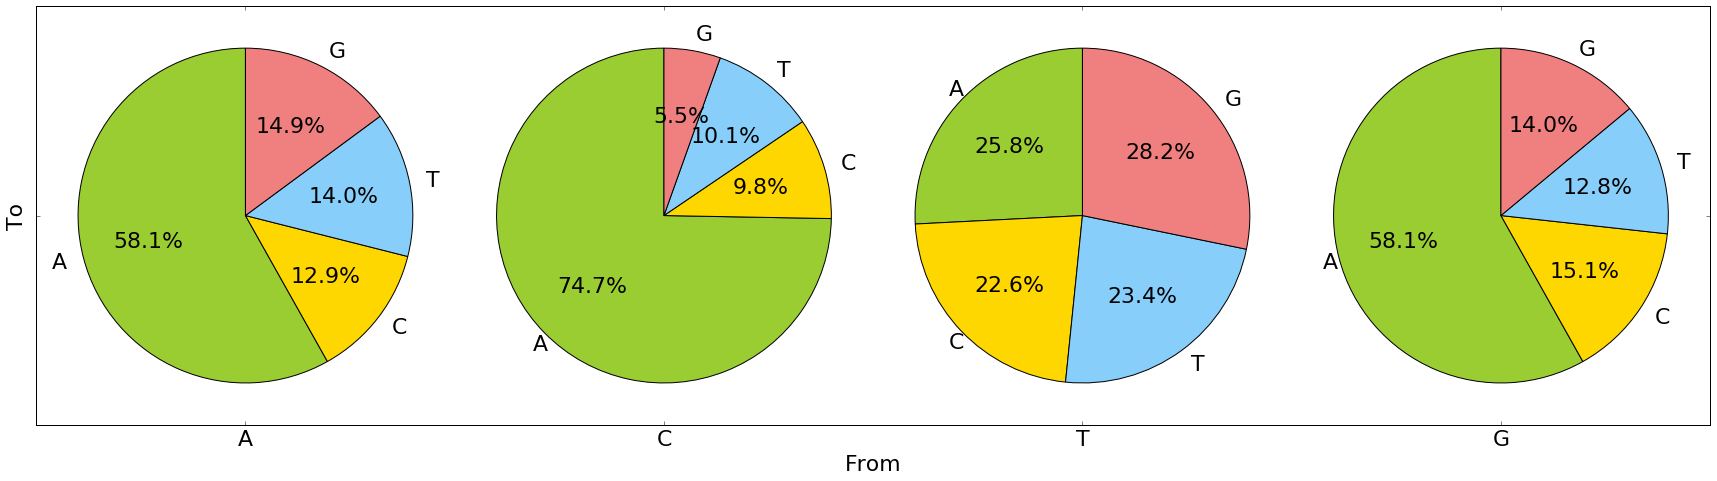

In [77]:
tr0 = tr[position]

fig = plt.figure()
ax = fig.gca()

ax.pie([tr0['A'][1][letter] for letter in alphabet], labels=alphabet, colors=colors, autopct='%1.1f%%', startangle=90,
       radius=0.4, center=(0, 0), frame=True)
ax.pie([tr0['C'][1][letter] for letter in alphabet], labels=alphabet, colors=colors, autopct='%1.1f%%', startangle=90,
       radius=0.4, center=(1, 0), frame=True)
ax.pie([tr0['T'][1][letter] for letter in alphabet], labels=alphabet, colors=colors, autopct='%1.1f%%', startangle=90,
       radius=0.4, center=(2, 0), frame=True)
ax.pie([tr0['G'][1][letter] for letter in alphabet], labels=alphabet, colors=colors, autopct='%1.1f%%', startangle=90,
       radius=0.4, center=(3, 0), frame=True)

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0])
ax.set_xticklabels(alphabet)
ax.set_yticklabels([""])
ax.set_xlim((-0.5, 3.5))
ax.set_ylim((-0.5, 0.5))
plt.xlabel("From")
plt.ylabel("To")

# Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_aspect('equal')

plt.rcParams.update({'font.size': 22, 'figure.figsize': (30.0, 8.0)})
plt.show()

### Compute the feature vectors for all data

In [78]:
def compute_vector(tr, x0):
    v = []
    for it in range(8):
        tr0 = tr[it]
        a = tr0[x0[it]][0]
        v.append(float(a) / len(U1))
        b = tr0[x0[it]][1][x0[it+1]]
        v.append(float(b) / a)
    it =  8
    tr0 = tr[it]
    a = tr0[x0[it]][0]
    v.append(float(a) / len(U1))
    return v
    
X=[]
for u1 in U1:
    v = compute_vector(tr, u1)
    X.append(v)
for u1 in U_rnd:
    v = compute_vector(tr, u1)
    X.append(v)
X = np.array(X)
y = np.concatenate((np.ones(len(U1)), np.zeros(len(U_rnd))))

## 4) machine learning

### train ML on data

We split first into train and test (80/20 %)

In [79]:
from sklearn import svm, preprocessing
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

# normalize the data attributes
normalized_X = preprocessing.normalize(X)
# standardize the data attributes
standardized_X = preprocessing.scale(X)

# don't overfit!!
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2)

## LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)


## 5) make predictions

And print report and confusion matrix.

In [80]:
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

        0.0       0.93      0.92      0.92       194
        1.0       0.92      0.93      0.93       206

avg / total       0.93      0.93      0.92       400

[[178  16]
 [ 14 192]]


## 6) Discussion

Much to discuss but one big issue is that the positive and negative training classes are well balanced, which is not representative of reality. Unbalancing them would not help the algorithm either.